# Описание процесса
Есть производство некоторого продукта посредством электролиза (нагреваемый ящик, стоит в неотапливаемом помещении).
Заглядывать в ящик часто нельзя - лабораторный сбор по уточнению процентного содержания в смеси происходит дважды
в день, хотелось бы делать замеры еще реже  и в перспективе полагатсья только на модель - отсюда и задача. 
Требуется предсказать по данным (до 2018-10-18) с различных датчиков процентное содержание продукта в 
смеси файл `target.csv`.
## В качестве данных доступны

**Файл `3min Series (00sec) Outer new`**:

- `Шум` в электрике
- `Обратная ЭДС` сети устройства
- `Ср.прир.напр` Средний прирост напряжения в сети
- `Сум.доз АПГ` Сумма доз АПГ (происходит периодичный вброс катализатора в ящик - это число соответствует 
	кол-ву раз которое производилось вбрасывание за промежуток времени)
- Температурные датчики (ящик прямоугольной формы, они рсполагаются по всему периметру, см `boards.png` - 
		схематическое расположение, нумерация вдоль длины ящика дана как пример)
	- `Board Temp. {i}` - датчики температуры по длинне ящика с обоих сторон
	- `Board Face Temp. {1,6}` - датчики с лицевой стороны
	- `Board Deaf Temp. {1,6}` - датчики с тыльной стороны

**Файл `Средняя масса доли АПГ New`** : массовые доли каждого из вбросов показателя `Сумма доз АПГ`. 
То есть можно понять сколько массы было вброшено в период `Итог масс АПГ = Сум.доз АПГ * avg_mass_apg`.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [2]:
def time(df):
    df_ = df.copy()
    df_['day'] = df_['Date'].dt.day
    df_['month'] = df_['Date'].dt.month
    df_['year'] = df_['Date'].dt.year
    df_['hour'] = df_['Date'].dt.hour

    df_.drop('Date', axis=1, inplace=True)
    return df_

# mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
# прочитаем данные

X = pd.read_csv('3min Series (00sec) Outer new.csv')
y = pd.read_csv('target.csv', delimiter=';')
X_m = pd.read_csv('Средняя масса доли АПГ New.csv')
y.columns = ['Date', 'product_percents']

In [4]:
# переведем в формат datetime

X['Date'] = pd.to_datetime(X['Date'])
X_m['Date'] = pd.to_datetime(X_m['Dateparse'])
X_m.drop('Dateparse', axis=1, inplace=True)
y['Date'] = pd.to_datetime(y['Date'])
y_te = y[y['product_percents'].isnull()]
y.dropna(inplace=True)

**Посмотрим, как устроена таблица с массовой долей каждого из вбросов показателя**

In [5]:
X_m.head(10)

,avg_mass_apg,Date
0,0.50,2018-07-30 23:00:00
1,0.51,2018-07-31 00:00:00
2,0.51,2018-07-31 01:00:00
3,0.51,2018-07-31 02:00:00
4,0.51,2018-07-31 03:00:00
5,0.51,2018-07-31 04:00:00
6,0.51,2018-07-31 05:00:00
7,0.51,2018-07-31 06:00:00
8,0.51,2018-07-31 07:00:00
9,0.51,2018-07-31 08:00:00


**Значения даны через каждый час, поэтому сделаем агрегацию по часу в основной таблице, чтобы присоединить таблицу с массовой долей каждого из вбросов**

In [6]:
# распарсим дату

X = time(X)
X_m = time(X_m)

In [7]:
X = X.groupby(['year', 'month', 'day', 'hour']).mean().reset_index()

In [8]:
X = X.merge(X_m[['avg_mass_apg', 'year', 'month', 'day', 'hour']], how='left', 
            on = ['year', 'month', 'day', 'hour'])

In [9]:
# посчитаем, сколько массы было вброшено в час

X['total'] = X['Сум.доз АПГ'] * X['avg_mass_apg']

**Сделаем флажок для первого и второго измерения в день**

Чтобы было проще ориентироваться, заменим значения 5 на 0 - знак первого измерения, а 14 на 1 - знак второго измерения

In [10]:
y = time(y)
y['part of day'] = y['hour'].apply(lambda x: 0 if x == 5 else 1)
y = y[['product_percents', 'day', 'month', 'year', 'part of day']]

y_te = time(y_te)
y_te['part of day'] = y_te['hour'].apply(lambda x: 0 if x == 5 else 1)
y_te = y_te[['product_percents', 'day', 'month', 'year', 'part of day']]

**Агрегируем по первому и второму измерению в день**

Считаем всю информаицю об измерениях за период от 5 до 14 часов, относяшуюся ко второму измерению, а остальную - к первому

In [11]:
X['part of day'] = X['hour'].apply(lambda x: 1 if ((x >= 5) and (x < 14)) else 0)

In [12]:
cols_for_features = list(X.columns)

**Добавим фичу с перепадами температур, ведь в электролизе важен перепад температур**

In [13]:
X['dif_face'] = X['Board Face Temp. 1'] - X['Board Face Temp. 6']
X['dif_deaf'] = X['Board Deaf Temp. 1'] - X['Board Deaf Temp. 6']

In [14]:
for i in range(2, 11):
    X['dif' + str(i)] = X['Board Temp. ' + str(i)] - X['Board Temp. ' + str(i-1)]

**Прежде чем агрегировать, добавим статистику по первому и второму измерению в течение дня**

In [15]:
df = X[cols_for_features].groupby(['year', 'month', 'day', 'part of day']).std()
df.columns = [el + '_std' for el in list(df.columns)]
df.reset_index(level=0, inplace=True)
X = X.merge(df, how='left', on = ['year', 'month', 'day', 'part of day'])

df = X[cols_for_features].groupby(['year', 'month', 'day', 'part of day']).min()
df.columns = [el + '_min' for el in list(df.columns)]
df.reset_index(level=0, inplace=True)
X = X.merge(df, how='left', on = ['year', 'month', 'day', 'part of day'])

df = X[cols_for_features].groupby(['year', 'month', 'day', 'part of day']).max()
df.columns = [el + '_max' for el in list(df.columns)]
df.reset_index(level=0, inplace=True)
X = X.merge(df, how='left', on = ['year', 'month', 'day', 'part of day'])

df = X[cols_for_features].groupby(['year', 'month', 'day', 'part of day']).sum()
df.columns = [el + '_sum' for el in list(df.columns)]
df.reset_index(level=0, inplace=True)
X = X.merge(df, how='left', on = ['year', 'month', 'day', 'part of day'])

cols_for_features.append('product_percents')
X = X.groupby(['year', 'month', 'day', 'part of day']).mean()
X = X.reset_index()

In [16]:
# собираем итоговый датасет

data_train = X.merge(y[['day', 'month', 'year', 'part of day', 'product_percents']], 
               on = ['day', 'month', 'year', 'part of day'], how='right')
data_test = X.merge(y_te[['day', 'month', 'year', 'part of day', 'product_percents']], 
                  on = ['day', 'month', 'year', 'part of day'], how='right')

In [17]:
# сортируем по дате

data_train = data_train.sort_values(by=['month', 'day', 'part of day'])
data_test = data_test.sort_values(by=['month', 'day', 'part of day'])

# Анализ данных

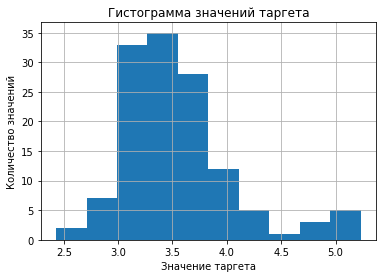

In [18]:
plt.hist(data_train['product_percents'], bins=10)
plt.title('Гистограмма значений таргета')
plt.xlabel('Значение таргета')
plt.ylabel('Количество значений')
plt.grid()
plt.show()

Распределение product_percents похоже на нормальное со средним значением 3.5, однако в правом хвосте наблюдается еще один пик.

In [19]:
data_train['product_percents'].describe()

count    131.000000
mean       3.539466
std        0.519146
min        2.430000
25%        3.165000
50%        3.480000
75%        3.745000
max        5.230000
Name: product_percents, dtype: float64

**Посмотрим на матрицу корреляций**

In [20]:
corr_matrix = data_train[cols_for_features].corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)


def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr_matrix.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,year,month,day,hour,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,Board Temp. 6,Board Temp. 7,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6,avg_mass_apg,total,part of day,product_percents
year,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
month,nan,1.00,-0.26,0.02,-0.38,-0.31,-0.10,0.40,0.34,-0.19,-0.45,-0.66,-0.12,0.55,-0.08,-0.64,-0.70,-0.12,-0.12,0.45,-0.03,0.14,-0.14,0.50,-0.02,-0.35
day,nan,-0.26,1.00,-0.01,-0.06,-0.25,0.13,0.09,0.24,-0.12,-0.58,-0.21,0.13,0.36,-0.38,-0.16,-0.33,0.30,0.05,0.29,-0.16,-0.04,-0.10,0.06,0.01,-0.09
hour,nan,0.02,-0.01,1.00,-0.11,-0.08,0.24,-0.02,0.08,0.03,0.03,0.07,0.02,0.09,0.03,0.10,0.06,0.04,0.11,0.11,0.08,0.13,-0.01,-0.02,-1.00,0.01
Шум,nan,-0.38,-0.06,-0.11,1.00,-0.03,0.13,-0.13,-0.22,0.07,0.23,0.15,-0.05,-0.37,-0.08,0.13,0.33,0.02,0.06,-0.29,-0.19,-0.12,0.00,-0.15,0.11,0.27
Обратная ЭДС,nan,-0.31,-0.25,-0.08,-0.03,1.00,-0.17,0.02,-0.08,0.46,0.32,0.04,-0.26,-0.28,0.08,0.11,0.09,0.12,-0.18,-0.33,0.08,-0.15,0.31,0.03,0.08,0.02
Ср.прир.напр.,nan,-0.10,0.13,0.24,0.13,-0.17,1.00,-0.12,0.07,0.10,0.02,0.13,0.16,-0.04,0.05,0.11,0.11,0.20,0.13,0.06,0.09,0.07,0.04,-0.12,-0.24,0.09
Сум.доз АПГ,nan,0.40,0.09,-0.02,-0.13,0.02,-0.12,1.00,-0.01,-0.37,-0.50,-0.74,-0.59,0.29,-0.43,-0.68,-0.62,-0.35,-0.47,0.07,-0.61,-0.20,-0.38,0.99,0.02,-0.61
Board Temp. 1,nan,0.34,0.24,0.08,-0.22,-0.08,0.07,-0.01,1.00,0.41,-0.25,-0.21,0.29,0.60,-0.13,-0.09,-0.46,0.57,0.48,0.56,0.53,0.33,0.14,0.02,-0.08,0.10
Board Temp. 2,nan,-0.19,-0.12,0.03,0.07,0.46,0.10,-0.37,0.41,1.00,0.26,0.10,0.12,0.11,0.29,0.32,-0.03,0.73,0.08,0.06,0.44,0.39,0.56,-0.29,-0.03,0.34


Таргет хорошо корреклирует почти со всеми признаками, кроме дня, часа, обратной ЭДС, ср. прир. напряжения.
Матрица корреляции отражает только линейные зависимости, так что отсутствие корреляции не означает того, что признак не важен.

Особенно сильна корреляция с суммарной дозой вбрасываемого катализатора (причем коэффициент отрицательный, то есть, чем больше катализатора, тем меньше значение доли вещества при замерении), что, вероятно, связано с тем, что количество катализатора сильно искажает результат эксперимента, поэтому и хочется делать манипуляций меньше.

In [21]:
import datetime

data_train['date_time'] = data_train.apply(lambda row :
                          datetime.datetime(int(row.year),int(row.month),int(row.day), int(row.hour)), 
                          axis=1)
data_test['date_time'] = data_test.apply(lambda row :
                          datetime.datetime(int(row.year),int(row.month),int(row.day), int(row.hour)), 
                          axis=1)

**Значение таргета в зависимости от дня**

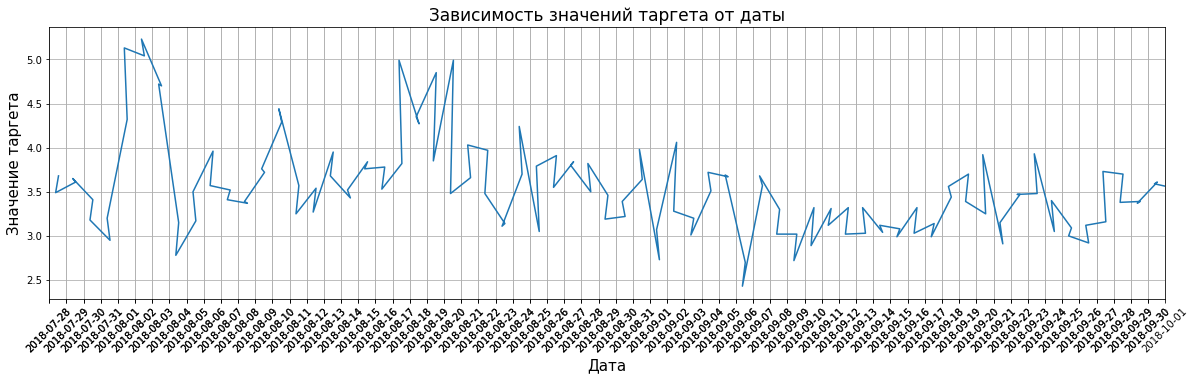

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(data_train['date_time'], data_train['product_percents'])
plt.title('Зависимость значений таргета от даты', fontsize=17)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Значение таргета', fontsize=15)
plt.xlim(data_train['date_time'].dt.date.min(), data_train['date_time'].dt.date.max())
plt.xticks(ticks=data_train['date_time'].dt.date, rotation=45)
plt.grid()
plt.show()

На графике присутствуют выбросы, однако колебания происходят около 3.5.

Это объяснимо: видимо, процентное содержание продукта в смеси как раз и надо поддерживать постоянным.

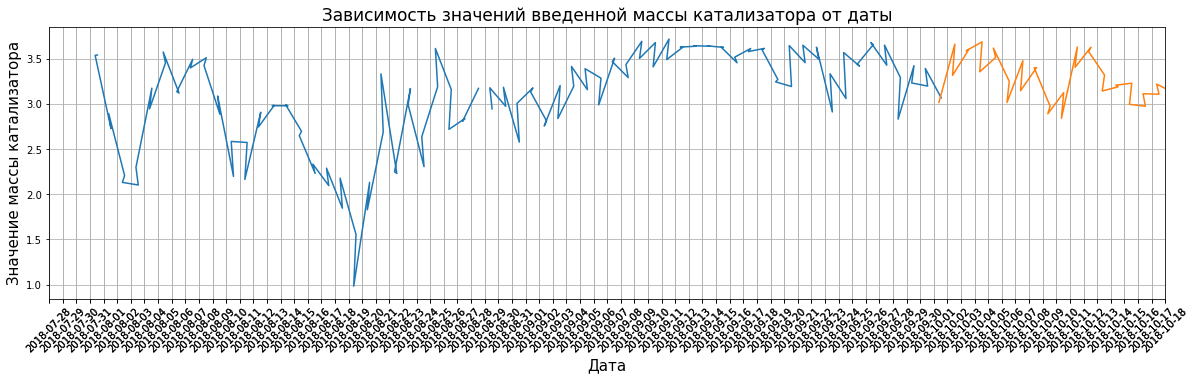

In [23]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(data_train['date_time'], data_train['total'])
plt.plot(data_test['date_time'], data_test['total'])
plt.title('Зависимость значений введенной массы катализатора от даты', fontsize=17)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Значение массы катализатора', fontsize=15)
plt.xticks(ticks=data_train['date_time'].dt.date.append(data_test['date_time'].dt.date), rotation=45)
plt.xlim(data_train['date_time'].dt.date.min(), data_test['date_time'].dt.date.max())
plt.show()

Имеется очень сильный минимум вбрасываемого катализатора 18 августа, хотя значение таргета в этой точке типичное.

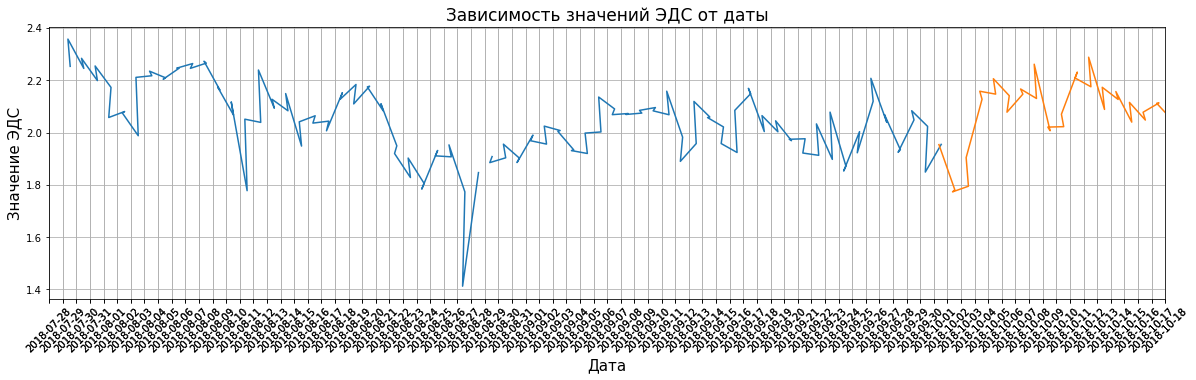

In [24]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(data_train['date_time'], data_train['Обратная ЭДС'])
plt.plot(data_test['date_time'], data_test['Обратная ЭДС'])
plt.title('Зависимость значений ЭДС от даты', fontsize=17)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Значение ЭДС', fontsize=15)
plt.xticks(ticks=data_train['date_time'].dt.date.append(data_test['date_time'].dt.date), rotation=45)
plt.xlim(data_train['date_time'].dt.date.min(), data_test['date_time'].dt.date.max())
plt.show()

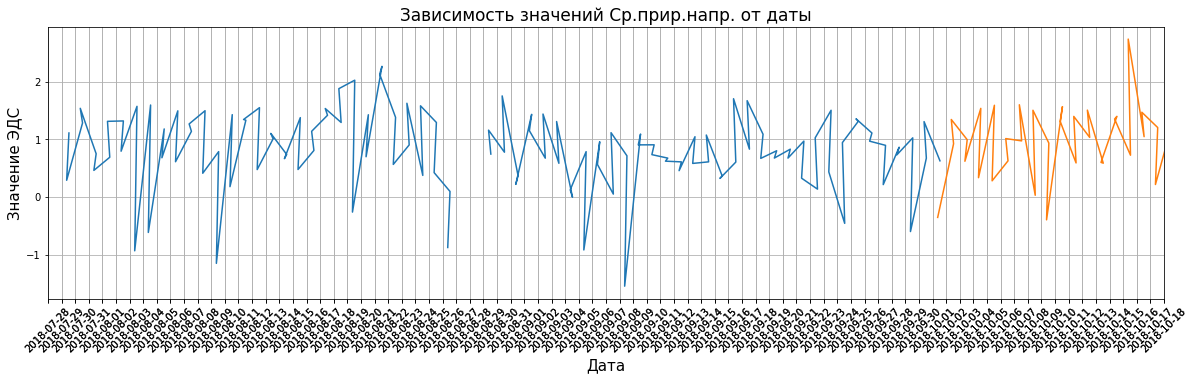

In [25]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(data_train['date_time'], data_train['Ср.прир.напр.'] + data_train['Обратная ЭДС'])
plt.plot(data_test['date_time'], data_test['Ср.прир.напр.'] + data_test['Обратная ЭДС'])
plt.title('Зависимость значений Ср.прир.напр. от даты', fontsize=17)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Значение ЭДС', fontsize=15)
plt.xticks(ticks=data_train['date_time'].dt.date.append(data_test['date_time'].dt.date), rotation=45)
plt.xlim(data_train['date_time'].dt.date.min(), data_test['date_time'].dt.date.max())
plt.show()

Имеется очень сильный минимум ЭДС на 26 августа, возможно, это как раз связано с низким содержанием катализатора в августе.

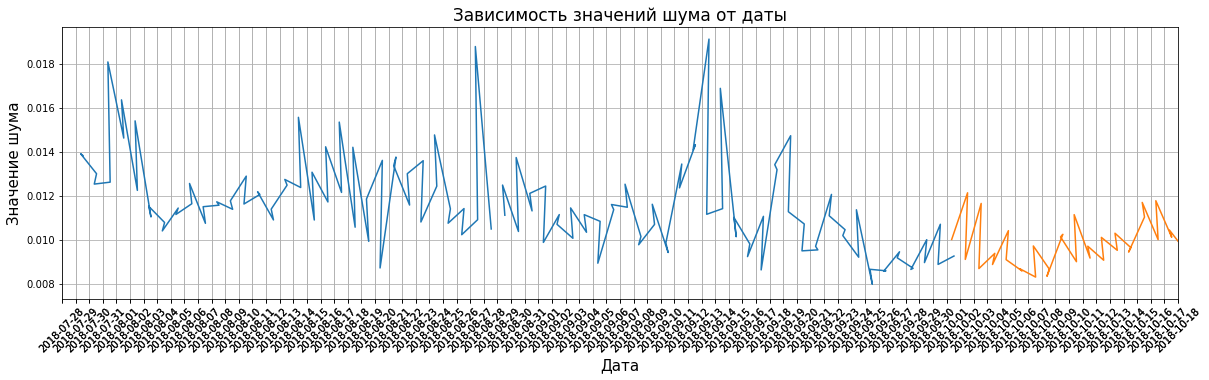

In [26]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(data_train['date_time'], data_train['Шум'])
plt.plot(data_test['date_time'], data_test['Шум'])
plt.title('Зависимость значений шума от даты', fontsize=17)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Значение шума', fontsize=15)
plt.xticks(ticks=data_train['date_time'].dt.date.append(data_test['date_time'].dt.date), rotation=45)
plt.xlim(data_train['date_time'].dt.date.min(), data_test['date_time'].dt.date.max())
plt.show()

In [27]:
data_train['Напряжение'] = data_train['Ср.прир.напр.'] + data_train['Обратная ЭДС'] + data_train['Шум']
data_test['Напряжение'] = data_test['Ср.прир.напр.'] + data_test['Обратная ЭДС'] + data_test['Шум']

data_train.drop(['Ср.прир.напр.', 'Шум', 'Обратная ЭДС'], axis=1, inplace=True)
data_test.drop(['Ср.прир.напр.', 'Шум', 'Обратная ЭДС'], axis=1, inplace=True)

**Сведем задачу прогнозирования временного ряда к регрессии, для этого добавим лаги по времени. Количество лагов подберем по валидации.**

In [28]:
# функция для добавления лагов

def add_shift_cols(df_, shift_n=1):
    df = df_.copy()
    for i in range(shift_n):
        df[f'lag_{i+1}'] = df['product_percents'].shift(i+1)
    return df

### Настройка модели LGMRegressor

Будем проводить кросс-валидацию с помощью TimeSeriesSplit.
Для начала настроим количество лагов

In [35]:
# настраиваем количество лагов

for n_lags in [2, 5, 10, 15, 20, 25, 30, 35]:
    
    data_train_new = add_shift_cols(data_train, n_lags)
    data_train_new.dropna(inplace=True)

    data_train_new.drop(['date_time', 'day', 'hour', 'month', 'year'], axis=1, inplace=True)

    X = data_train_new.loc[:, data_train_new.columns != 'product_percents'].to_numpy()
    y = data_train_new['product_percents']

    scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

    model = LGBMRegressor()
    param_search = {'objective' : ['mape']}
    tscv = TimeSeriesSplit(n_splits=7, test_size=2)
    gsearch = GridSearchCV(estimator=model, cv=tscv, scoring=scorer, param_grid = param_search, n_jobs=-1)
    gsearch.fit(X, y)
    print('Score: ', abs(gsearch.best_score_), 'n_lags: ', n_lags)

Score:  6.49723337228865 n_lags:  2
Score:  6.043713444890238 n_lags:  5
Score:  6.272488342267507 n_lags:  10
Score:  6.8925672801929005 n_lags:  15
Score:  6.695906013353833 n_lags:  20
Score:  5.829072622155114 n_lags:  25
Score:  6.692651477887848 n_lags:  30
Score:  6.472252129636418 n_lags:  35


Лучшее качество было показано при 25 лагах.
Теперь настроим гиперпараметры.

In [36]:
data_train_new = add_shift_cols(data_train, 25)
data_train_new.dropna(inplace=True)

data_train_new.drop(['date_time', 'day', 'hour', 'month', 'year'], axis=1, inplace=True)

X = data_train_new.loc[:, data_train_new.columns != 'product_percents'].to_numpy()
y = data_train_new['product_percents']

scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

model = LGBMRegressor()
param_search = {
                'max_depth' : [3, 5, 7, 9, 11],
                'learning_rate' : [0.001, 0.01, 0.05, 0.1],
                'n_estimators' : [50, 100, 200, 500],
                'reg_alpha' : [0, 0.5, 1, 1.5, 2], 
                'objective' : ['mape']
               }

tscv = TimeSeriesSplit(n_splits=7, test_size=2)
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search, scoring=scorer, n_jobs=-1)
gsearch.fit(X, y)
# print('Grid best parameter: ', gsearch.best_params_)
print('Score: ', abs(gsearch.best_score_))

Grid best parameter:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'objective': 'mape', 'reg_alpha': 1.5}
Grid best score:  5.111860342101707


**Ошибка на валидации получилась MAPE = 5.11 %**

Чтобы понимать, насколько это хорошо, посмотрим, какое качество даст константное предсказание равное среднему.

In [41]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")

param_search = {}

gsearch_const = GridSearchCV(estimator=dummy_regr, cv=tscv,
                        param_grid=param_search, scoring=scorer, n_jobs=-1)
gsearch_const.fit(X, y)
print('Score: ', abs(gsearch_const.best_score_))

Score:  7.442578517229032


**Решение, полученное с помощью модели LGBMRegressor на 2.33 % дает лучше значение метрики MAPE**

### Предсказания на тесте

In [38]:
# добавим лаги

data = pd.concat([data_train, data_test]).sort_values(by=['date_time','part of day'])
data_lags = add_shift_cols(data, 25).sort_values(by=['date_time','part of day'])

data_tr = data_lags.iloc[:-data_test.shape[0], :]
data_tr.dropna(inplace=True)
data_te = data_lags.iloc[-data_test.shape[0]:]

# сохраняем информацию о дате, чтобы визуализировать потом
time = data_te.apply(lambda row:
                              datetime.datetime(int(row.year),int(row.month),int(row.day), int(row['part of day'])), 
                              axis=1)
data_te.drop(['product_percents', 'date_time', 'day', 'hour', 'month', 'year'], axis=1, inplace=True)

data_te.fillna(-1, inplace=True)
pred = gsearch.predict(data_te)

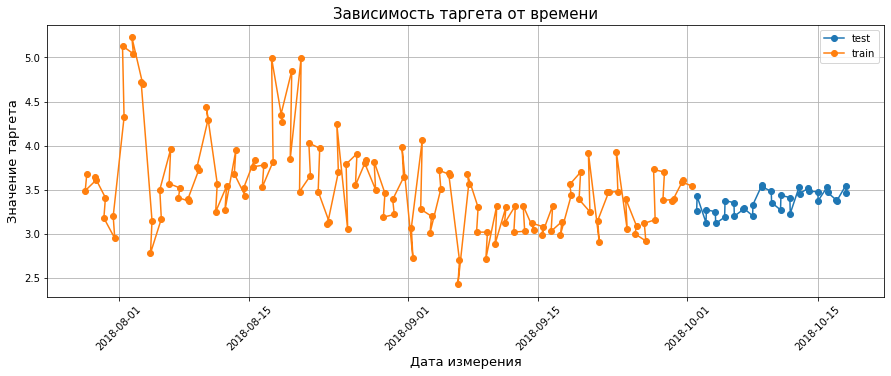

In [80]:
# визуализация предсказаний

result = pd.concat([time, pd.Series(pred)], axis=1)
result.dropna(inplace=True)
result.columns = ['time', 'pred']
result_ = result.sort_values(by=['time'])

plt.figure(figsize=(15, 5))
plt.plot(result['time'], result['pred'], label = 'test', marker='o')
plt.plot(data_train['date_time'], data_train['product_percents'], label = 'train', marker='o')
plt.title('Зависимость таргета от времени', fontsize=15)
plt.xlabel('Дата измерения', fontsize=13)
plt.ylabel('Значение таргета', fontsize=13)
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Запись результата в файл

In [72]:
df = pd.read_csv('target.csv', sep = ';')
df.columns = ['time', 'y']

y = df['y'].dropna()
y = pd.concat([y, pd.Series(pred)])
df['y'] = y.to_numpy()
df.to_csv('result.csv')